In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.interpolate import interp1d

from PIL import Image

import os
import re

from collections import defaultdict

from scipy.signal import savgol_filter, savgol_coeffs
from scipy.optimize import curve_fit

import math

import json

## General Tool Functions

In [2]:
def theta3_from_a(a, tol=1e-14, nmax=100000):
    """
    Evaluate θ3(0, e^{-a}) robustly using modular transformation when needed.
    a > 0.
    θ3(0,q) = 1 + 2 * sum_{n=1}^\infty q^{n^2}, q = exp(-a).
    """
    if a <= 0:
        raise ValueError("Parameter 'a' must be positive.")
    # Map q = exp(-π t) form: here a = π t  => t = a/π
    t = a / math.pi
    if t < 1.0:
        # Use modular transformation: θ3(0, e^{-π t}) = t^{-1/2} θ3(0, e^{-π/t})
        t_inv = 1.0 / t
        q_small = math.exp(-math.pi * t_inv)
        # Fast convergence since q_small is tiny
        s = 1.0
        n = 1
        term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * math.exp(-math.pi * t_inv * n * n)
        return s / math.sqrt(t)
    else:
        # Direct series
        q = math.exp(-math.pi * t)
        s = 1.0
        n = 1
        term = 2.0 * q ** (n * n)
        while term > tol and n < nmax:
            s += term
            n += 1
            term = 2.0 * q ** (n * n)
        return s

def G_of_rho(rho):
    # G(ρ) = θ3(e^{-ρ^2}) / θ3(e^{-ρ^2/2})^2
    a1 = rho**2
    a2 = rho**2 / 2.0
    th1 = theta3_from_a(a1)
    th2 = theta3_from_a(a2)
    return th1 / (th2**2)

def M2_of_rho(rho):
    """
    Dimensionless second moment for discrete Gaussian weights.
    For small rho, use continuum asymptotic 1/rho^2 (accurate up to exponentially small error).
    Otherwise compute via truncated symmetric sum.
    """
    if rho < 0.05:
        return 1.0 / (rho**2)
    # Choose truncation based on width ~ 1/rho. Take 6 sigma-equivalent.
    M = max(10, int(math.ceil(8.0 / rho)))
    # Symmetric sum; m=0 contributes to Z only
    Z = 1.0
    num = 0.0
    c = -0.5 * rho**2
    for m in range(1, M+1):
        w = math.exp(c * m * m)
        Z += 2.0 * w
        num += 2.0 * (m*m) * w
    return num / Z

def mu2_of_rho(rho, dQ):
    # μ2(ρ) = ΔQ^2 * M2(ρ)
    return (dQ**2) * M2_of_rho(rho)

In [3]:
# Data structure to hold scattering data
class ScatteringData:
    def __init__(self, Q, I, I_err, dQ, total_counts=None):
        index = Q > 0
        self.Q = Q[index]
        self.I = I[index]
        self.I_err = I_err[index]
        self.dQ = dQ[index]
        self.total_counts = total_counts  # Store total detector counts
        
# manual rebinning
def rebin_data(scattering_data, rebin_factor):
    """
    Manually rebin scattering data by a given integer factor.
    Propagates uncertainty correctly.
    """
    if not isinstance(rebin_factor, int) or rebin_factor < 1:
        raise ValueError("Rebin factor must be an integer greater than 1.")
    
    Q_orig = scattering_data.Q
    I_orig = scattering_data.I
    I_err_orig = scattering_data.I_err
    dQ_orig = scattering_data.dQ

    # Pad data if necessary to make it divisible by the rebin factor
    padding = rebin_factor - (len(Q_orig) % rebin_factor)
    if padding != rebin_factor:
        Q_padded = np.pad(Q_orig, (0, padding), 'edge')
        I_padded = np.pad(I_orig, (0, padding), 'edge')
        I_err_padded = np.pad(I_err_orig, (0, padding), 'edge')
    else:
        Q_padded = Q_orig
        I_padded = I_orig
        I_err_padded = I_err_orig

    num_new_bins = len(Q_padded) // rebin_factor
    
    # Reshape and rebin
    Q_new = np.mean(Q_padded.reshape(-1, rebin_factor), axis=1)
    I_new = np.mean(I_padded.reshape(-1, rebin_factor), axis=1)
    
    # Propagate uncertainty (sum in quadrature, then average)
    I_err_new = np.sqrt(np.sum(I_err_padded.reshape(-1, rebin_factor)**2, axis=1)) / rebin_factor
    
    # Calculate new bin width: interpolate dQ to Q_new and multiply by rebin factor
    dQ_interp = interp1d(Q_orig, dQ_orig, kind='linear', bounds_error=False, fill_value='extrapolate')
    dQ_new = dQ_interp(Q_new) * rebin_factor
    
    return ScatteringData(Q_new, I_new, I_err_new, np.full_like(Q_new, dQ_new))

# Error calculations
def calculate_avg_counting_error(scattering_data):
    """Calculates the average squared counting error from the I_err array."""
    return np.mean(scattering_data.I_err**2)

def calculate_avg_binning_error_dQ4(dQ, integral_val, L):
    """
    Backup function to calculate the average squared binning distortion for a given bin size.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**4 / (576 * L)) * integral_val

def calculate_avg_binning_error(dQ, integral_val, L):
    """
    Calculates the average squared binning distortion based on the new formula.
    """
    if L == 0:
        return np.inf  # Avoid division by zero
    return (dQ**2 / (12 * L)) * integral_val

def calculate_structural_lengthscale(scattering_data):
    """
    Calculates the background-insensitive structural lengthscale (Ls)
    from a ScatteringData object.

    Ls = sqrt(integral[(I(Q) - <I>)^2 dQ] / integral[(I'(Q))^2 dQ])

    Args:
        scattering_data (ScatteringData): An object containing Q and I arrays.

    Returns:
        float: The calculated structural lengthscale, or NaN if calculation fails.
    """
    Q = scattering_data.Q
    I = scattering_data.I

    # Check for sufficient data points
    if len(Q) < 5:
        print("Not enough data points to calculate derivatives accurately.")
        return np.nan

    # Calculate the average intensity <I>
    avg_I = np.mean(I)

    # 1. Calculate the numerator: Integral of squared deviation from the mean
    #    (This is proportional to the variance of the signal)
    I_minus_avg_I_squared = (I - avg_I)**2
    numerator_integral = np.trapz(I_minus_avg_I_squared, Q)

    # 2. Calculate the denominator: Integral of the squared first derivative
    #    Use Savitzky-Golay filter to get the derivative
    avg_dQ = np.mean(np.diff(Q))
    smoothed_I_prime = savgol_filter(I, window_length=5, polyorder=4, deriv=1, delta=avg_dQ)
    I_prime_squared = smoothed_I_prime**2
    denominator_integral = np.trapz(I_prime_squared, Q)

    # Handle the case where the curve is flat (denominator is zero)
    if denominator_integral == 0:
        return np.inf

    # 3. Calculate the lengthscale
    lengthscale = np.sqrt(numerator_integral / denominator_integral)
    
    return lengthscale

# define interpolation function for evaluating the best quality I(Q) as ground truth
def interpolate_best_I(best_data, Q_query, window_length=5, polyorder=3):
    Q_best = best_data.Q
    I_best = best_data.I
    # Use Savitzky-Golay filter for C2 continuity (2nd derivative continuous)
    # Choose window_length and polyorder for smoothness (must be odd and polyorder < window_length)
    window_length = window_length
    polyorder = polyorder
    I_best_smooth = savgol_filter(I_best, window_length=window_length, polyorder=polyorder)
    interp_func = interp1d(Q_best, I_best_smooth, kind='linear', bounds_error=False, fill_value='extrapolate')
    return interp_func(Q_query)

# GPR and error estimation
def rbf_kernel(x, y, length):
    """Radial basis function (RBF) kernel for GPR."""
    dx2 = (x[:, None] - y[None, :])**2
    return np.exp(-0.5 * dx2 / (length**2))

def gpr_posterior_mean(Q_train, y_train, noise_var, length, s2=1.0, jitter=1e-10, D2=None):
    Q = np.ascontiguousarray(Q_train, dtype=np.float64)
    y = np.ascontiguousarray(y_train, dtype=np.float64)
    n = Q.shape[0]

    # Reuse distances if provided
    if D2 is None:
        # Pre-scale once to save a division in the exponent
        X = Q / length
        D2 = (X[:, None] - X[None, :])**2          # = (Q_i-Q_j)^2 / length^2
        K = s2 * np.exp(-0.5 * D2)
    else:
        K = s2 * np.exp(-0.5 * D2 / (length*length))

    # Fast diag add, scalar/vector unified
    if np.isscalar(noise_var):
        K.ravel()[::n+1] += (noise_var + jitter)
        nv = noise_var
    else:
        nv = np.ascontiguousarray(noise_var, dtype=y.dtype)
        K.ravel()[::n+1] += nv + jitter

    L = np.linalg.cholesky(K)
    z = np.linalg.solve(L, y)
    z = np.linalg.solve(L.T, z)

    mu = y - (nv * z if not np.isscalar(nv) else nv * z)
    return mu

import numpy as np

# ---------- RBF helpers ----------
def _rbf_col(X, i, length, s2=1.0):
    """Return the i-th kernel column k(:, i) for RBF without forming K."""
    X = np.asarray(X, dtype=np.float64)
    if X.ndim == 1:
        diff2 = (X - X[i])**2
    else:
        diff = X - X[i]
        diff2 = np.sum(diff*diff, axis=1)
    inv_l2 = 0.5 / (length*length)   # = 1/(2 ℓ^2)
    return s2 * np.exp(-inv_l2 * diff2)

# ---------- Pivoted Cholesky factor (K ≈ U U^T) ----------
def pivoted_cholesky_rbf(X, length, s2=1.0, max_rank=256, tol=1e-10):
    """
    Build low-rank factor U (n×r) s.t. K ≈ U U^T for RBF kernel.
    K_ij = s2 * exp(-||x_i - x_j||^2 / (2 ℓ^2)).
    diag(K) = s2 (constant), so initial residual diag = s2 * ones.

    Returns
    -------
    U : (n, r) array
    pivots : (r,) pivot indices used
    resid_diag : (n,) final residual diagonal (K - U U^T)_ii
    """
    X = np.asarray(X, dtype=np.float64)
    n = X.shape[0]
    rmax = min(max_rank, n)

    U = np.zeros((n, rmax), dtype=np.float64)
    resid = np.full(n, float(s2))         # residual diag
    pivots = np.empty(rmax, dtype=int)

    used = np.zeros(n, dtype=bool)
    for r in range(rmax):
        i = int(np.argmax(resid))
        piv = resid[i]
        if piv <= tol:
            # truncate
            U = U[:, :r]
            pivots = pivots[:r]
            break
        pivots[r] = i
        used[i] = True

        # c = k(:, i) - sum_{t<r} U[:,t] * U[i,t]
        col = _rbf_col(X, i, length, s2=s2)
        if r > 0:
            proj = U[:, :r] @ U[i, :r]
            col = col - proj

        U[:, r] = col / np.sqrt(piv)
        # update residual diag: resid -= u_r^2
        resid -= U[:, r]**2
        # numerical guard
        np.maximum(resid, 0.0, out=resid)

    else:
        # filled rmax
        pivots = pivots[:rmax]

    return U, pivots, resid

# ---------- Woodbury solver for (D + U U^T) z = y ----------
def woodbury_solve(U, D, y):
    """
    Solve (D + U U^T) z = y with D diagonal (vector of length n).
    Uses: z = D^{-1} y - D^{-1} U (I + U^T D^{-1} U)^{-1} U^T D^{-1} y
    """
    U = np.asarray(U, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64)
    D = np.asarray(D, dtype=np.float64)
    invD = 1.0 / D

    # Compute small system A = I + U^T D^{-1} U  (m x m)
    # and rhs b = U^T D^{-1} y
    UDinv = U * invD[:, None]        # n×m
    A = np.eye(U.shape[1], dtype=np.float64) + (U.T @ UDinv)
    b = U.T @ (invD * y)

    # Solve A w = b (SPD => Cholesky)
    L = np.linalg.cholesky(A)
    w = np.linalg.solve(L, b)
    w = np.linalg.solve(L.T, w)

    # Back to z
    z = invD * y - (invD[:, None] * U) @ w
    return z

# ---------- High-level: posterior mean at training points ----------
def gpr_posterior_mean_lowrank(X, y, noise_var, length, s2=1.0, jitter=1e-10,
                               max_rank=256, tol=1e-10, U_precomputed=None):
    """
    Compute μ = y - Σ (K+Σ)^{-1} y using a low-rank K ≈ U U^T (pivoted Cholesky) and Woodbury.

    Parameters
    ----------
    X : (n,d) or (n,) array of inputs
    y : (n,) array
    noise_var : float or (n,) array   (Σ diagonal entries)
    length : float (RBF ℓ)
    s2 : float (signal variance)
    jitter : float, added to the *solver* diagonal only (not to Σ in μ = y - Σ z)
    max_rank : int, target rank
    tol : float, pivot stopping tolerance on residual diagonal
    U_precomputed : optional (n,r) factor to reuse; if provided, skips factorization

    Returns
    -------
    mu : (n,) posterior mean at training points
    U : (n,r) low-rank factor (for reuse across multiple y)
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.ascontiguousarray(y, dtype=np.float64)
    n = X.shape[0]

    if U_precomputed is None:
        U, piv, resid = pivoted_cholesky_rbf(X, length, s2=s2, max_rank=max_rank, tol=tol)
    else:
        U = np.asarray(U_precomputed, dtype=np.float64)

    # Build diagonal D = Σ + jitter
    if np.isscalar(noise_var):
        D = np.full(n, noise_var + jitter, dtype=np.float64)
        Sigma = noise_var
    else:
        nv = np.asarray(noise_var, dtype=np.float64)
        D = nv + jitter
        Sigma = nv  # used elementwise below

    # Solve (K+Σ+jitter I) z = y with low-rank K via Woodbury
    z = woodbury_solve(U, D, y)

    # μ = y - Σ z  (IMPORTANT: use Σ only, not Σ+jitter)
    if np.isscalar(Sigma):
        mu = y - Sigma * z
    else:
        mu = y - Sigma * z
    return mu

# gpr_posterior_mean = gpr_posterior_mean_lowrank  # alias

# --- helpers: local (rebinned) beta/gamma/A0 from (Q, y) ---
# --- optional Savitzky–Golay prefilter for derivative/integral estimates ---
try:
    from scipy.signal import savgol_filter
    _HAS_SG = True
except Exception:
    _HAS_SG = False

def _odd(n):  # ensure odd window length
    return n if (n % 2 == 1) else (n + 1)

def _integrals_from_Qy(Q, y, sg=None):
    """
    Compute L, mean_I, beta, gamma, A0 from (Q,y).
    If sg is not None and scipy is available, apply Savitzky–Golay smoothing
    to estimate I', I'' with reduced noise.

    Parameters
    ----------
    Q, y : 1D arrays (Q strictly increasing)
    sg : dict or None, e.g.
         dict(window_frac=0.15, polyorder=3)  # defaults if omitted
    """
    Q = np.asarray(Q, float)
    y = np.asarray(y, float)
    assert np.all(np.isfinite(Q)) and np.all(np.isfinite(y)), "NaNs in Q/y"
    assert np.all(np.diff(Q) > 0), "Q must be strictly increasing"

    L = float(Q[-1] - Q[0])
    mean_I = float(np.trapz(y, Q) / L)

    if sg and _HAS_SG and len(Q) >= 7:
        # --- SG settings ---
        window_frac = float(sg.get("window_frac", 0.15))
        polyorder   = int(sg.get("polyorder", 3))
        n           = len(Q)
        # window based on fraction of samples; clamp to [polyorder+2, n-1]
        w = max(polyorder + 2, int(round(window_frac * n)))
        w = min(w, n - (1 - (n % 2)))     # ensure <= n and odd-able
        w = _odd(max(w, 5))               # at least 5 and odd
        # w = 5

        # use median spacing as delta (good for mild non-uniform grids)
        dQ_med = float(np.median(np.diff(Q)))

        # smooth value and get derivatives via SG (deriv wrt Q):
        y_s  = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=0, delta=dQ_med, mode="interp")
        I1   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=1, delta=dQ_med, mode="interp")
        I2   = savgol_filter(y, window_length=w, polyorder=polyorder, deriv=2, delta=dQ_med, mode="interp")
    else:
        # fallback: raw gradients (works for non-uniform spacing)
        I1 = np.gradient(y, Q)
        I2 = np.gradient(I1, Q)

    int_I1_sq = float(np.trapz(I1*I1, Q))
    int_I2_sq = float(np.trapz(I2*I2, Q))

    beta  = int_I1_sq / (12.0 * L)
    gamma = int_I2_sq / ( 4.0 * L)
    A0    = L * (mean_I ** 2)
    return L, mean_I, beta, gamma, A0

def dimless_mse(pred, truth):
    """Dimensionless mean squared error, normalized by mean(truth)^2."""
    mean_truth = float(np.mean(truth))
    mean_truth = mean_truth if mean_truth != 0 else 1.0
    return float(np.mean((pred - truth)**2)) / (mean_truth**2)

In [4]:
def calculate_slope_integral(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative based on the new derivation.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I

    # Use Savitzky-Golay filter to get the first derivative of intensity with respect to Q
    smoothed_I_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=1, delta=np.mean(np.diff(Q_best)))
    
    # Square the first derivative.
    I_prime_squared = smoothed_I_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_prime_squared, Q_best)
    
    return integral_val

def calculate_slope_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculates the integral of the squared FIRST derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=1
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=1, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_prime = D @ I
    I_prime_sq = I_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def calculate_curvature_integral(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative.
    This value is a constant for the entire dataset.
    """
    Q_best = data.Q
    I_best = data.I
    
    # Use Savitzky-Golay filter to get the second derivative of intensity with respect to Q
    smoothed_I_double_prime = savgol_filter(I_best, window_length=window_length, polyorder=polyorder, deriv=2, delta=np.mean(np.diff(Q_best)))
    
    # Square the second derivative.
    I_double_prime_squared = smoothed_I_double_prime**2
    
    # Integrate the squared first derivative over the Q range.
    integral_val = np.trapz(I_double_prime_squared, Q_best)
    
    return integral_val

def calculate_curvature_integral_with_uncertainty(data, window_length=5, polyorder=4):
    """
    Calculate the integral of the squared second derivative and its uncertainty.
    """
    Q, I, I_err = np.asarray(data.Q), np.asarray(data.I), np.asarray(data.I_err)
    delta = np.mean(np.diff(Q))
    n = len(I)

    # Savitzky–Golay differentiation matrix for derivative=2
    half_win = window_length // 2
    coeffs = savgol_coeffs(window_length, polyorder, deriv=2, delta=delta)
    D = np.zeros((n, n))
    for i in range(n):
        for k, c in enumerate(coeffs):
            j = i + k - half_win
            if 0 <= j < n:
                D[i, j] = c

    I_double_prime = D @ I
    I_double_prime_sq = I_double_prime**2
    w = np.gradient(Q)

    J = np.trapz(I_double_prime_sq, Q)

    # Uncertainty propagation
    dJdI = 2 * (w[:, None] * I_double_prime[:, None]) * D   # shape (n, n)
    sigma_J_sq = np.sum((dJdI**2) * I_err[None, :]**2)
    sigma_J = np.sqrt(sigma_J_sq)

    return J, sigma_J

def f_beta(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the beta parameter 
    """
    beta = calculate_slope_integral(data, window_length, polyorder) / (12.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_slope_integral_with_uncertainty(data, window_length, polyorder)
        beta, beta_std = integral / (12.0 * (data.Q.max() - data.Q.min())), integral_std / (12.0 * (data.Q.max() - data.Q.min()))
        return beta, beta_std
    return beta

def f_gamma(data, window_length=5, polyorder=4, std=False):
    """
    Calculate the gamma parameter 
    """
    gamma = calculate_curvature_integral(data, window_length, polyorder) / (4.0 * (data.Q.max() - data.Q.min()))
    if std:
        integral, integral_std = calculate_curvature_integral_with_uncertainty(data, window_length, polyorder)
        gamma, gamma_std = integral / (4.0 * (data.Q.max() - data.Q.min())), integral_std / (4.0 * (data.Q.max() - data.Q.min()))
        return gamma, gamma_std
    return gamma

def f_alpha(data, total_counts):
    """
    Calculate the A0 parameter 
    """
    L = data.Q.max() - data.Q.min()
    mean_I = np.mean(data.I)
    return L * (mean_I ** 2)/ total_counts

## Visualization

Results from analysis_HANARO.json:
alpha*n = 7.5316e-01
beta  = 1.4099e+06 ± 1.5072e+04
gamma = 2.5534e+12 ± 2.2096e+10
pre_factor = 1.4473e+02
n_cross = 1000000.0, E_cross = 0.0063730988149884185
Results from analysis_D22.json:
alpha*n = 4.0852e-02
beta  = 1.6934e-01 ± 4.5244e-04
gamma = 3.8690e+02 ± 3.8492e+00
pre_factor = 1.5280e-01
n_cross = 10000000.0, E_cross = 4.3450084073082014e-07
Results from analysis_USANS32871_r.json:
alpha*n = 8.9469e+05
beta  = 1.2265e+15 ± 8.3712e+12
gamma = 2.1784e+23 ± 1.1957e+21
pre_factor = 1.6092e+09
n_cross = 3000000.0, E_cross = 23105.431616792863
Results from analysis_USANS28523.json:
alpha*n = 2.0084e+03
beta  = 1.3664e+13 ± 1.7774e+12
gamma = 1.4858e+22 ± 1.6364e+21
pre_factor = 7.1500e+06
n_cross = 10000000.0, E_cross = 34.313640497185446
Results from analysis_EQSANS23463.json:
alpha*n = 1.7675e+01
beta  = 1.9971e+04 ± 1.4392e+03
gamma = 9.9658e+09 ± 7.7582e+08
pre_factor = 5.9596e+02
n_cross = 3000000.0, E_cross = 0.00466671133763534
Results 

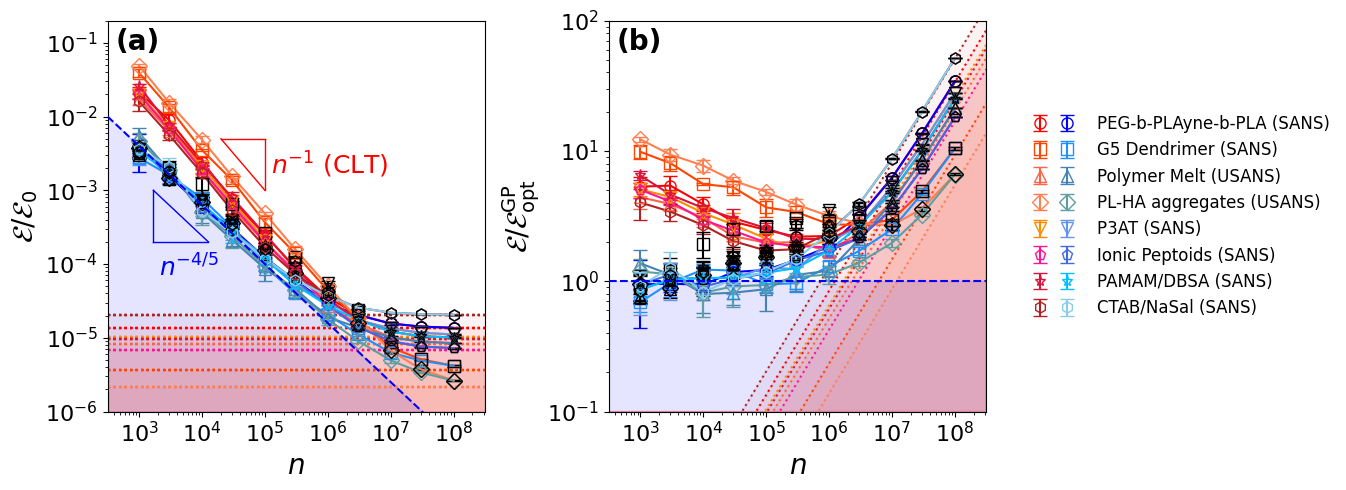

In [9]:
filename_json_list = ["analysis_HANARO.json", "analysis_D22.json", "analysis_USANS32871_r.json", "analysis_USANS28523.json", 
                      "analysis_EQSANS23463.json", "analysis_EQSANS22170.json", "analysis_EQSANS25953.json", "analysis_EQSANS22386.json"]
# label_list = ["HANARO", "D22","USANS (32871)", "USANS (28523)", 
#               "EQSANS (23463)", "EQSANS (22170)", "EQSANS (25953)", "EQSANS (22386)"]
label_list = ["PEG-b-PLAyne-b-PLA (SANS)", "G5 Dendrimer (SANS)","Polymer Melt (USANS)", "PL-HA aggregates (USANS)", 
              "P3AT (SANS)", "Ionic Peptoids (SANS)", "PAMAM/DBSA (SANS)", "CTAB/NaSal (SANS)"]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
count_list_fine = np.logspace(2.5, 8.5, 100)
# Define red-ish and blue-ish colors based on CIE 1931 uniform chromaticity
colors_red = ['#FF0000', '#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FF1493', '#DC143C', '#B22222']  # 8 red-ish colors
colors_blue = ['#0000FF', '#1E90FF', '#4682B4', '#5F9EA0', '#6495ED', '#4169E1', '#00BFFF', '#87CEEB']  # 8 blue-ish colors
symbols = ['o', 's', '^', 'D', 'v', 'p', '*', 'h']
alpha = 1

for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    # pre_factor = mise_GP_stat[0,0,4]/count_list[0]**(-4/5)
    # Fit pre_factor using the first three points of mise_GP_stat[:,0,4] in log-log space
    def linear_fit(x, b):
        return -4/5 * x + b

    log_count_list = np.log(count_list[:4])
    log_mise_GP = np.log(mise_GP_stat[:4, 0, 4])

    popt, _ = curve_fit(linear_fit, log_count_list, log_mise_GP)
    pre_factor = np.exp(popt[0])  # Convert intercept back to linear space
    
    # Calculate the intersection point
    E_cross = (mise_GP_stat[:, 0, 2] + mise_GP_stat[:, 0, 3])
    n_cross = count_list[np.argmin(np.abs(pre_factor * count_list**(-4/5) - E_cross))]
    print(f"n_cross = {n_cross}, E_cross = {E_cross[np.argmin(np.abs(pre_factor * count_list**(-4/5) - E_cross))]}")
    
    ax1.errorbar(count_list, mise_instr_stat[:,0,4]/pre_factor, yerr=mise_instr_stat[:,1,4]/pre_factor, linestyle='', markersize=8, fillstyle='none', capsize=5, color=cr, alpha=alpha, marker=symbols[idx])
    ax1.errorbar(count_list, mise_GP_stat[:,0,4]/pre_factor, yerr=mise_GP_stat[:,1,4]/pre_factor, linestyle='', markersize=8, fillstyle='none', capsize=5, color=cb, alpha=alpha, marker=symbols[idx])
    ax1.errorbar(count_list, mise_FD_stat[:,0,4]/pre_factor, yerr=mise_FD_stat[:,1,4]/pre_factor, linestyle='', markersize=8, fillstyle='none', capsize=5, color='k', alpha=alpha, marker=symbols[idx])
    ax1.plot(count_list, mise_instr_stat[:,0,4]/pre_factor, linestyle='-', color=cr, alpha=alpha)
    ax1.plot(count_list, mise_GP_stat[:,0,4]/pre_factor, linestyle='-', color=cb, alpha=alpha)
    
    ax1.hlines((mise_GP_stat[:,0,2]+mise_GP_stat[:,0,3])/pre_factor, xmin=count_list_fine[0], xmax=count_list_fine[-1], colors=cr, linestyles=':', zorder=-10, alpha=alpha)
    ax1.fill_between(count_list_fine, np.ones_like(count_list_fine)*1e-6, ((mise_GP_stat[0,0,2]+mise_GP_stat[0,0,3]))*np.ones_like(count_list_fine)/pre_factor, color=cr, alpha=0.05, zorder=-21)
    
    ax2.errorbar(count_list, mise_instr_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_instr_stat[:,1,4]/pre_factor/count_list**(-4/5), linestyle='', markersize=8, fillstyle='none', capsize=5, color=cr, alpha=alpha, marker=symbols[idx], label=' ')
    ax2.plot(count_list, mise_instr_stat[:,0,4]/pre_factor/count_list**(-4/5), linestyle='-', color=cr, alpha=alpha)
    ax2.plot(count_list, mise_GP_stat[:,0,4]/pre_factor/count_list**(-4/5), linestyle='-', color=cb, alpha=alpha)
    
    ax2.plot(count_list_fine, (mise_instr_stat[0,0,2]+mise_instr_stat[0,0,3])/pre_factor/count_list_fine**(-4/5), ':', color=cr, zorder=-10, alpha=alpha)
    ax2.fill_between(count_list_fine, np.ones_like(count_list_fine)*1e-1, ((mise_instr_stat[0,0,2]+mise_instr_stat[0,0,3]))*np.ones_like(count_list_fine)/pre_factor/count_list_fine**(-4/5), color=cr, alpha=0.05, zorder=-21)
    
for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    # pre_factor = mise_GP_stat[0,0,4]/count_list[0]**(-4/5)
    # Fit pre_factor using the first three points of mise_GP_stat[:,0,4] in log-log space
    def linear_fit(x, b):
        return -4/5 * x + b

    log_count_list = np.log(count_list[:4])
    log_mise_GP = np.log(mise_GP_stat[:4, 0, 4])

    popt, _ = curve_fit(linear_fit, log_count_list, log_mise_GP)
    pre_factor = np.exp(popt[0])  # Convert intercept back to linear space
    
    ax2.errorbar(count_list, mise_GP_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_GP_stat[:,1,4]/pre_factor/count_list**(-4/5), linestyle='', markersize=8, fillstyle='none', capsize=5, color=cb, alpha=alpha, marker=symbols[idx], label=label_list[idx])
    ax2.errorbar(count_list, mise_FD_stat[:,0,4]/pre_factor/count_list**(-4/5), yerr=mise_FD_stat[:,1,4]/pre_factor/count_list**(-4/5), linestyle='', markersize=8, fillstyle='none', capsize=5, color='k', alpha=alpha, marker=symbols[idx])
    
ax1.plot(count_list_fine, count_list_fine**(-4/5), '--', color='b', zorder=20)
ax1.fill_between(count_list_fine, np.ones_like(count_list_fine)*1e-6, count_list_fine**(-4/5), color='b', alpha=0.1, zorder=-21)
ax2.plot(count_list_fine, count_list_fine**(-4/5)/count_list_fine**(-4/5), '--', color='b', zorder=20)
ax2.fill_between(count_list_fine, np.ones_like(count_list_fine)*1e-1, count_list_fine**(-4/5)/count_list_fine**(-4/5), color='b', alpha=0.1, zorder=-21)
    
ax1.set_xlabel(r'$n$', fontsize=20)
ax1.set_ylabel(r'$\mathcal{E} /\mathcal{E}_0$', fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax1.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax1.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax1.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax1.set_ylim(1e-6, 2e-1)
ax1.set_xlim(count_list_fine[0], count_list_fine[-1])
# ax1.grid(True, which='major', linestyle='--', linewidth=0.5)
ax1.text(0.02, 0.98, "(a)", transform=ax1.transAxes, ha='left', va='top', fontsize=20, fontweight='bold')

y_triangle = np.array([5e-3, 1e-3])
x_triangle = 1e2 / y_triangle 
ax1.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='r', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='r', lw=1)
ax1.text(x_triangle[1] * 1.25, np.sqrt(y_triangle[0] * y_triangle[1]), r"$n^{-1}$ (CLT)", fontsize=18, va='center', ha='left', color='r')

y_triangle = np.array([2e-4, 1e-3])
x_triangle = 0.3 / y_triangle**(5/4) 
ax1.plot([x_triangle[1], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='b', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[0]], '-', color='b', lw=1)
ax1.plot([x_triangle[0], x_triangle[1]], [y_triangle[0], y_triangle[1]], '-', color='b', lw=1)
ax1.text(x_triangle[1] * 1.25, np.sqrt(y_triangle[0] * y_triangle[1])/5 , r"$n^{-4/5}$", fontsize=18, va='center', ha='left', color='b')

ax2.set_xlabel(r'$n$', fontsize=20)
ax2.set_ylabel(r'$\mathcal{E}/\mathcal{E}^\mathrm{GP}_\mathrm{opt}$', fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.xaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax2.xaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax2.yaxis.set_major_locator(matplotlib.ticker.LogLocator(base=10.0, numticks=10))
ax2.yaxis.set_minor_locator(matplotlib.ticker.LogLocator(base=10.0, subs='auto', numticks=100))
ax2.set_ylim(1e-1, 1e2)
ax2.set_xlim(count_list_fine[0], count_list_fine[-1])
ax2.text(0.02, 0.98, "(b)", transform=ax2.transAxes, ha='left', va='top', fontsize=20, fontweight='bold')

ax2.legend(fontsize=12, frameon=False, loc='right', bbox_to_anchor=(1.95, 0.5), ncol=2, columnspacing=-1.5)

plt.tight_layout()

In [11]:
mise_FD_stat.shape

(11, 2, 9)

In [16]:
import json
import numpy as np

# ---------------- user inputs ----------------
filename_json_list = [
    "analysis_HANARO.json", "analysis_D22.json", "analysis_USANS32871_r.json", "analysis_USANS28523.json",
    "analysis_EQSANS23463.json", "analysis_EQSANS22170.json", "analysis_EQSANS25953.json", "analysis_EQSANS22386.json"
]

label_list = [
    "PEG-b-PLAyne-b-PLA",
    "G5 Dendrimer",
    "Polymer Melt",
    "PL-HA aggregates",
    "P3AT",
    "Ionic Peptoids",
    "PAMAM/DBSA",
    "CTAB/NaSal"
]

targets = np.array([1e3, 3e5, 1e8], dtype=float)

# ---------------- helpers ----------------
def closest_index(arr, target):
    arr = np.asarray(arr, dtype=float).ravel()
    return int(np.argmin(np.abs(arr - target)))

def reduce_to_scalar(x, mode="mean"):
    a = np.asarray(x, dtype=float)
    if a.ndim == 0:
        return float(a)
    a = a.ravel()
    if a.size == 0:
        return float("nan")
    if mode == "mean":
        return float(np.nanmean(a))
    if mode == "median":
        return float(np.nanmedian(a))
    if mode == "min":
        return float(np.nanmin(a))
    if mode == "max":
        return float(np.nanmax(a))
    if mode == "4":
        return float(a[4])
    raise ValueError(mode)

def mise_at_index(mise_stat, i, reduce_mode="mean"):
    if isinstance(mise_stat, np.ndarray) and np.asarray(mise_stat).dtype != object:
        a = np.asarray(mise_stat, dtype=float)
        return float(a[i]) if a.ndim == 1 else reduce_to_scalar(a[i], reduce_mode)
    return reduce_to_scalar(mise_stat[i], reduce_mode)

# --- CHANGE 1: return plain numeric strings (for siunitx alignment) ---
def sci_tex(x, sig=3):
    """
    Return a plain numeric string like '1.23e4' (NOT LaTeX math).
    Use with siunitx S columns to align decimal points and the exponent-product.
    """
    if x is None or not np.isfinite(x):
        return ""
    return f"{float(x):.{sig}g}"

# --- CHANGE 2: ratios also as plain numbers for S columns ---
def dec_tex(x, ndp=3):
    """Return a plain decimal string like '0.973' (NOT LaTeX math)."""
    if x is None or not np.isfinite(x):
        return ""
    return f"{float(x):.{ndp}f}"

# ---------------- table generator ----------------
def make_fixed_count_table(
    filename_json_list,
    label_list,
    *,
    targets=targets,
    mise_reduce="mean",
    swap_fd_gp=True,          # set False if your json is consistent
    err_sig=3,                # significant digits for errors
    ratio_ndp=3,              # decimals for ratios
    caption=r"Comparison at fixed total counts $n=10^3$, $3\times10^5$, and $10^8$.",
    label="tab:fixed_count_comparison"
):
    lines = []
    lines.append(r"\begin{table}")
    lines.append(r"\centering")
    lines.append(r"\caption{" + caption + r"}")
    lines.append(r"\label{" + label + r"}")

    # --- CHANGE 3: use siunitx S columns to align decimals and \times 10^b ---
    # Requires LaTeX preamble:
    # \usepackage{siunitx}
    # \sisetup{scientific-notation=true, exponent-product=\times, output-product=\times}
    lines.append(
        r"\begin{tabularx}{\linewidth}{"
        r"l "
        r"S[scientific-notation=true, round-mode=figures, round-precision=1]"
        r"S[scientific-notation=true, table-format=1.2e2] "
        r"S[scientific-notation=true, table-format=1.2e2] "
        r"S[scientific-notation=true, table-format=1.2e2] "
        r"c "
        r"c "
        r"c"
        r"}"
    )

    lines.append(r"\hline\hline")
    lines.append(
        r"Sample & {$n$} & {$\mathcal{E}^{\mathrm{instr}}$} & {$\mathcal{E}^{\mathrm{FD}}$} & {$\mathcal{E}^{\mathrm{GP}}$} & "
        r"{$\mathcal{E}^{\mathrm{FD}}/\mathcal{E}^{\mathrm{instr}}$} & "
        r"{$\mathcal{E}^{\mathrm{GP}}/\mathcal{E}^{\mathrm{instr}}$} & "
        r"{$\mathcal{E}^{\mathrm{GP}}/\mathcal{E}^{\mathrm{FD}}$} \\"
    )
    lines.append(r"\hline")

    for fname, sample in zip(filename_json_list, label_list):
        with open(fname, "r") as f:
            d = json.load(f)

        count_list = np.asarray(d["count_list"], dtype=float).ravel()

        E_stat   = d["mise_instr_stat"]
        FD_stat  = d["mise_FD_stat"]
        GP_stat  = d["mise_GP_stat"]

        for n_target in targets:
            i = closest_index(count_list, n_target)

            n_used = float(count_list[i])
            E  = mise_at_index(E_stat,  i, mise_reduce)

            FD = mise_at_index(FD_stat, i, mise_reduce)
            GP = mise_at_index(GP_stat, i, mise_reduce)

            if swap_fd_gp:
                FD, GP = GP, FD

            r_FD_E  = FD / E  if (np.isfinite(FD) and np.isfinite(E)  and E  != 0) else np.nan
            r_GP_E  = GP / E  if (np.isfinite(GP) and np.isfinite(E)  and E  != 0) else np.nan
            r_GP_FD = GP / FD if (np.isfinite(GP) and np.isfinite(FD) and FD != 0) else np.nan

            label_sample = sample if n_target == targets[0] else ""

            lines.append(
                f"{label_sample} & "
                f"{sci_tex(n_used, sig=1)} & "          # <-- n: ONE significant digit
                f"{sci_tex(E,      sig=err_sig)} & "
                f"{sci_tex(FD,     sig=err_sig)} & "
                f"{sci_tex(GP,     sig=err_sig)} & "
                f"{dec_tex(r_FD_E,  ndp=ratio_ndp)} & "
                f"{dec_tex(r_GP_E,  ndp=ratio_ndp)} & "
                f"{dec_tex(r_GP_FD, ndp=ratio_ndp)} \\\\"
            )


        lines.append(r"\hline")

    lines.append(r"\end{tabularx}")
    lines.append(r"\end{table}")
    return "\n".join(lines)

latex_table = make_fixed_count_table(
    filename_json_list, label_list,
    swap_fd_gp=True,      # keep True if your json has FD/GP swapped
    err_sig=3,
    ratio_ndp=3
)

print(latex_table)


\begin{table}
\centering
\caption{Comparison at fixed total counts $n=10^3$, $3\times10^5$, and $10^8$.}
\label{tab:fixed_count_comparison}
\begin{tabularx}{\linewidth}{l S[scientific-notation=true, round-mode=figures, round-precision=1]S[scientific-notation=true, table-format=1.2e2] S[scientific-notation=true, table-format=1.2e2] S[scientific-notation=true, table-format=1.2e2] c c c}
\hline\hline
Sample & {$n$} & {$\mathcal{E}^{\mathrm{instr}}$} & {$\mathcal{E}^{\mathrm{FD}}$} & {$\mathcal{E}^{\mathrm{GP}}$} & {$\mathcal{E}^{\mathrm{FD}}/\mathcal{E}^{\mathrm{instr}}$} & {$\mathcal{E}^{\mathrm{GP}}/\mathcal{E}^{\mathrm{instr}}$} & {$\mathcal{E}^{\mathrm{GP}}/\mathcal{E}^{\mathrm{FD}}$} \\
\hline
PEG-b-PLAyne-b-PLA & 1e+03 & 3.15 & 2.13 & 0.461 & 0.678 & 0.147 & 0.216 \\
 & 3e+05 & 0.0124 & 0.0092 & 0.0119 & 0.743 & 0.959 & 1.291 \\
 & 1e+08 & 0.00145 & 0.00144 & 0.000817 & 0.993 & 0.565 & 0.569 \\
\hline
G5 Dendrimer & 1e+03 & 0.00366 & 0.00313 & 0.000194 & 0.855 & 0.053 & 0.062 \\
 & 

In [21]:
import json
import numpy as np

# ---------------- user inputs ----------------
filename_json_list = [
    "analysis_HANARO.json", "analysis_D22.json", "analysis_USANS32871_r.json", "analysis_USANS28523.json",
    "analysis_EQSANS23463.json", "analysis_EQSANS22170.json", "analysis_EQSANS25953.json", "analysis_EQSANS22386.json"
]

label_list = ["PEG-b-PLAyne-b-PLA (SANS)", "G5 Dendrimer (SANS)","Polymer Melt (USANS)", "PL-HA aggregates (USANS)", 
              "P3AT (SANS)", "Ionic Peptoids (SANS)", "PAMAM/DBSA (SANS)", "CTAB/NaSal (SANS)"]

targets = np.array([1e3, 3e5, 1e8], dtype=float)

# ---------------- helpers ----------------
def closest_index(arr, target):
    arr = np.asarray(arr, dtype=float).ravel()
    return int(np.argmin(np.abs(arr - target)))

def reduce_to_scalar(x, mode="mean"):
    a = np.asarray(x, dtype=float)
    if a.ndim == 0:
        return float(a)
    a = a.ravel()
    if a.size == 0:
        return float("nan")
    if mode == "mean":
        return float(np.nanmean(a))
    if mode == "median":
        return float(np.nanmedian(a))
    if mode == "min":
        return float(np.nanmin(a))
    if mode == "max":
        return float(np.nanmax(a))
    if mode == "4":
        return float(a[4])
    raise ValueError(mode)

def mise_at_index(mise_stat, i, reduce_mode="mean"):
    if isinstance(mise_stat, np.ndarray) and np.asarray(mise_stat).dtype != object:
        a = np.asarray(mise_stat, dtype=float)
        return float(a[i]) if a.ndim == 1 else reduce_to_scalar(a[i], reduce_mode)
    return reduce_to_scalar(mise_stat[i], reduce_mode)

# --- return plain numeric strings for siunitx alignment ---
def sci_tex(x, sig=3):
    if x is None or not np.isfinite(x):
        return ""
    return f"{float(x):.{sig}g}"

def dec_tex(x, ndp=3):
    if x is None or not np.isfinite(x):
        return ""
    return f"{float(x):.{ndp}f}"

# ---------------- table generator ----------------
def make_fixed_count_table(
    filename_json_list,
    label_list,
    *,
    targets=targets,
    mise_reduce="4",
    swap_fd_gp=False,
    err_sig=3,
    ratio_ndp=3,
    caption=r"Comparison at fixed total counts $n=10^3$, $3\times10^5$, and $10^8$.",
    label="tab:fixed_count_comparison"
):
    lines = []
    lines.append(r"\begin{table}")
    lines.append(r"\centering")
    lines.append(r"\caption{" + caption + r"}")
    lines.append(r"\label{" + label + r"}")

    # Grouped format: sample name on its own row spanning all columns.
    # Requires LaTeX preamble:
    # \usepackage{tabularx}
    # \usepackage{siunitx}
    # \sisetup{scientific-notation=true, exponent-product=\times, output-product=\times}
    lines.append(
        r"\begin{tabularx}{\linewidth}{"
        r"S[scientific-notation=true, round-mode=figures, round-precision=1]"
        r"S[scientific-notation=true, table-format=1.2e2] "
        r"S[scientific-notation=true, table-format=1.2e2] "
        r"S[scientific-notation=true, table-format=1.2e2] "
        r"c "
        r"c "
        r"c"
        r"}"
    )

    lines.append(r"\hline\hline")
    lines.append(
        "\rule{0pt}{2.5ex}"
        r"{$n$} & {$\mathcal{E}^{\mathrm{instr}}$} & {$\mathcal{E}^{\mathrm{FD}}$} & {$\mathcal{E}^{\mathrm{GP}}$} & "
        r"{$\mathcal{E}^{\mathrm{FD}}/\mathcal{E}^{\mathrm{instr}}$} & "
        r"{$\mathcal{E}^{\mathrm{GP}}/\mathcal{E}^{\mathrm{instr}}$} & "
        r"{$\mathcal{E}^{\mathrm{GP}}/\mathcal{E}^{\mathrm{FD}}$} \\"
    )
    lines.append(r"\hline")

    for fname, sample in zip(filename_json_list, label_list):
        with open(fname, "r") as f:
            d = json.load(f)

        count_list = np.asarray(d["count_list"], dtype=float).ravel()

        E_stat  = d["mise_instr_stat"]
        FD_stat = d["mise_FD_stat"]
        GP_stat = d["mise_GP_stat"]

        # --- Sample name row (spans all 7 columns) ---
        lines.append(rf"\multicolumn{{7}}{{l}}{{\textbf{{{sample}}}}} \\")
        # Optional: tiny extra vertical space (comment out if you don't want it)
        # lines.append(r"\multicolumn{7}{l}{\rule{0pt}{2.2ex}\textbf{" + sample + r"}} \\")

        for n_target in targets:
            i = closest_index(count_list, n_target)

            n_used = float(count_list[i])
            E  = mise_at_index(E_stat,  i, mise_reduce)
            FD = mise_at_index(FD_stat, i, mise_reduce)
            GP = mise_at_index(GP_stat, i, mise_reduce)

            if swap_fd_gp:
                FD, GP = GP, FD

            r_FD_E  = FD / E  if (np.isfinite(FD) and np.isfinite(E)  and E  != 0) else np.nan
            r_GP_E  = GP / E  if (np.isfinite(GP) and np.isfinite(E)  and E  != 0) else np.nan
            r_GP_FD = GP / FD if (np.isfinite(GP) and np.isfinite(FD) and FD != 0) else np.nan

            lines.append(
                f"{sci_tex(n_used, sig=1)} & "          # n: ONE significant digit
                f"{sci_tex(E,      sig=err_sig)} & "
                f"{sci_tex(FD,     sig=err_sig)} & "
                f"{sci_tex(GP,     sig=err_sig)} & "
                f"{dec_tex(r_FD_E,  ndp=ratio_ndp)} & "
                f"{dec_tex(r_GP_E,  ndp=ratio_ndp)} & "
                f"{dec_tex(r_GP_FD, ndp=ratio_ndp)} \\\\"
            )

        lines.append(r"\hline")

    lines.append(r"\end{tabularx}")
    lines.append(r"\end{table}")
    return "\n".join(lines)

latex_table = make_fixed_count_table(
    filename_json_list, label_list,
    swap_fd_gp=False,
    err_sig=3,
    ratio_ndp=3
)

print(latex_table)


\begin{table}
\centering
\caption{Comparison at fixed total counts $n=10^3$, $3\times10^5$, and $10^8$.}
\label{tab:fixed_count_comparison}
\begin{tabularx}{\linewidth}{S[scientific-notation=true, round-mode=figures, round-precision=1]S[scientific-notation=true, table-format=1.2e2] S[scientific-notation=true, table-format=1.2e2] S[scientific-notation=true, table-format=1.2e2] c c c}
\hline\hline
ule{0pt}{2.5ex}{$n$} & {$\mathcal{E}^{\mathrm{instr}}$} & {$\mathcal{E}^{\mathrm{FD}}$} & {$\mathcal{E}^{\mathrm{GP}}$} & {$\mathcal{E}^{\mathrm{FD}}/\mathcal{E}^{\mathrm{instr}}$} & {$\mathcal{E}^{\mathrm{GP}}/\mathcal{E}^{\mathrm{instr}}$} & {$\mathcal{E}^{\mathrm{GP}}/\mathcal{E}^{\mathrm{FD}}$} \\
\hline
\multicolumn{7}{l}{\textbf{PEG-b-PLAyne-b-PLA (SANS)}} \\
1e+03 & 10.1 & 1.62 & 1.79 & 0.161 & 0.178 & 1.103 \\
3e+05 & 0.0433 & 0.0433 & 0.0288 & 1.000 & 0.665 & 0.665 \\
1e+08 & 0.00647 & 0.00647 & 0.00647 & 1.000 & 1.000 & 1.000 \\
\hline
\multicolumn{7}{l}{\textbf{G5 Dendrimer (SANS)}} 

Results from analysis_HANARO.json:
alpha*n = 7.5316e-01
beta  = 1.4099e+06 ± 1.5072e+04
gamma = 2.5534e+12 ± 2.2096e+10
pre_factor = 1.4473e+02
Results from analysis_D22.json:
alpha*n = 4.0852e-02
beta  = 1.6934e-01 ± 4.5244e-04
gamma = 3.8690e+02 ± 3.8492e+00
pre_factor = 1.5280e-01
Results from analysis_USANS32871_r.json:
alpha*n = 8.9469e+05
beta  = 1.2265e+15 ± 8.3712e+12
gamma = 2.1784e+23 ± 1.1957e+21
pre_factor = 1.6092e+09
Results from analysis_USANS28523.json:
alpha*n = 2.0084e+03
beta  = 1.3664e+13 ± 1.7774e+12
gamma = 1.4858e+22 ± 1.6364e+21
pre_factor = 7.1500e+06
Results from analysis_EQSANS23463.json:
alpha*n = 1.7675e+01
beta  = 1.9971e+04 ± 1.4392e+03
gamma = 9.9658e+09 ± 7.7582e+08
pre_factor = 5.9596e+02
Results from analysis_EQSANS22170.json:
alpha*n = 2.9437e-01
beta  = 9.1590e+02 ± 2.3736e+01
gamma = 8.7741e+08 ± 5.4579e+07
pre_factor = 1.3848e+01
Results from analysis_EQSANS25953.json:
alpha*n = 4.3885e+01
beta  = 1.6388e+06 ± 5.3322e+04
gamma = 1.9612e+12 ± 6.095

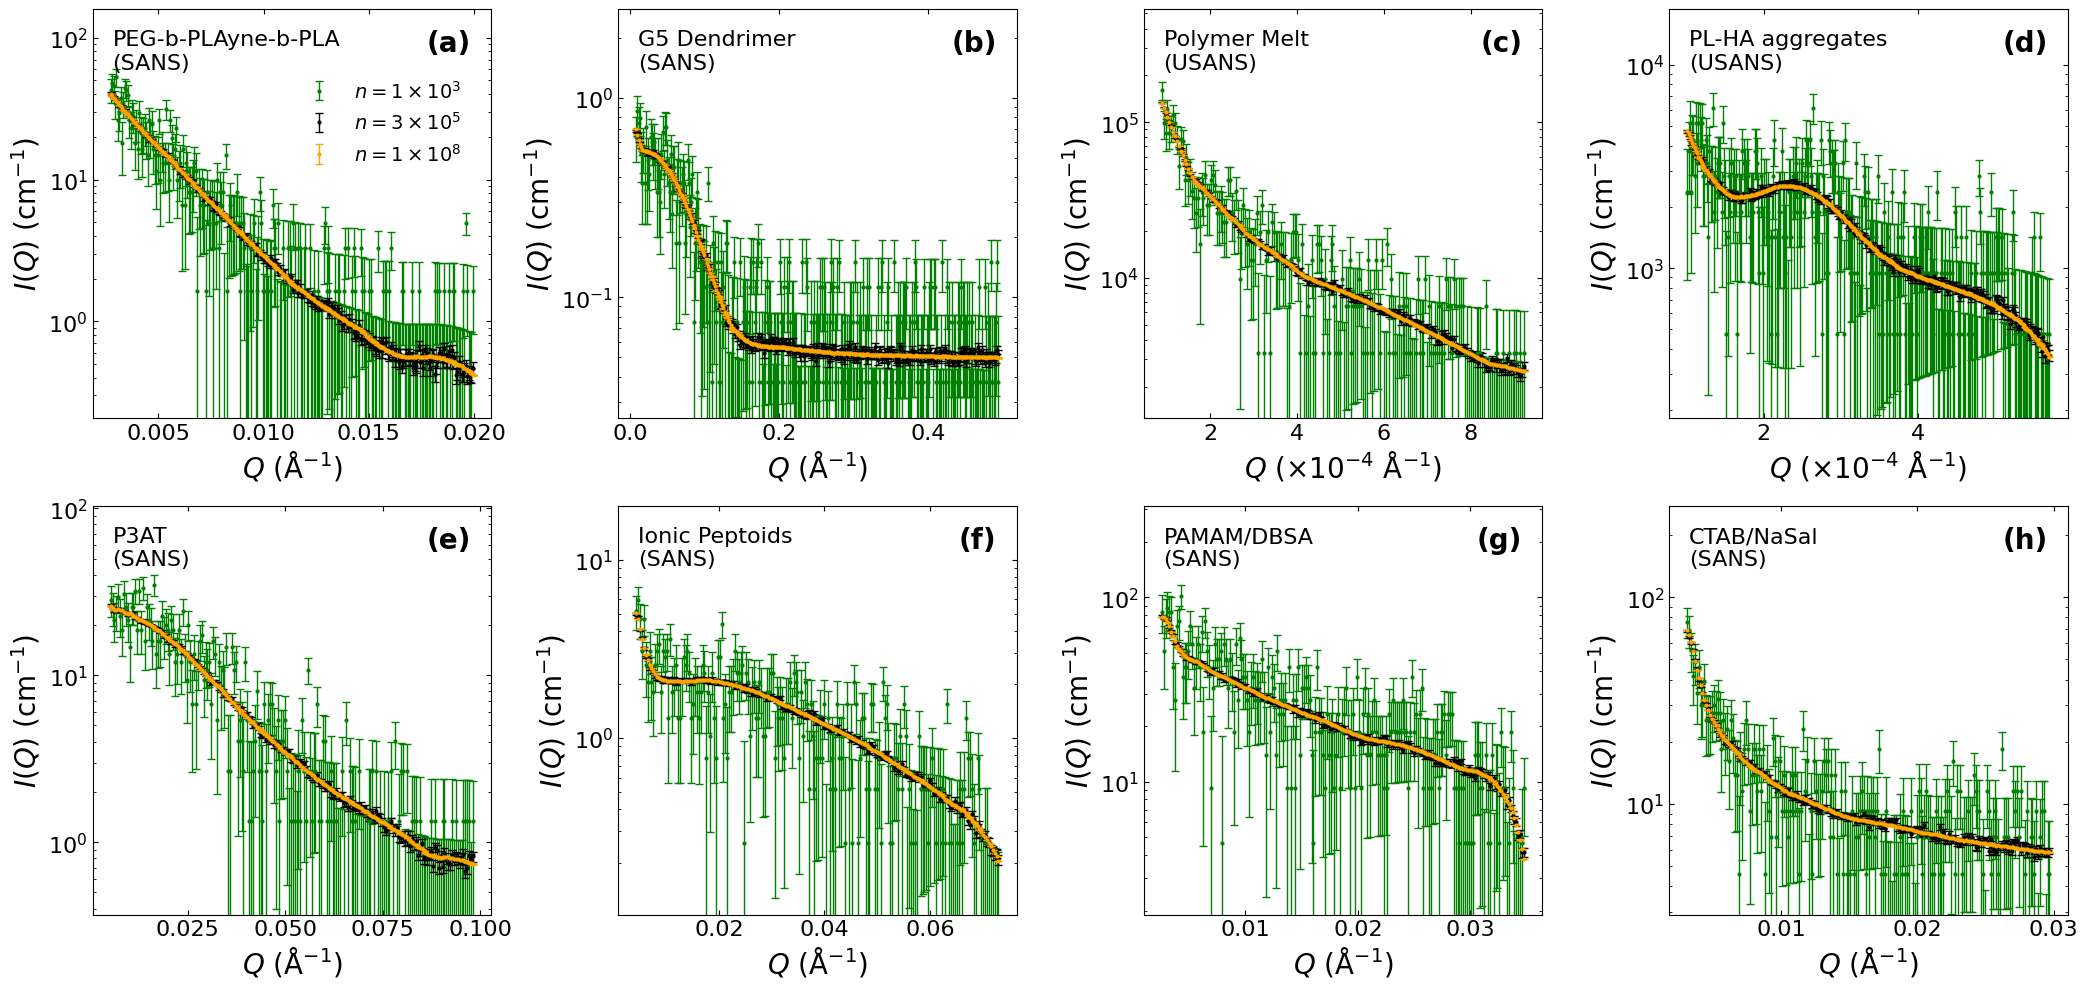

In [8]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import ScalarFormatter


filename_json_list = ["analysis_HANARO.json", "analysis_D22.json", "analysis_USANS32871_r.json", "analysis_USANS28523.json", 
                      "analysis_EQSANS23463.json", "analysis_EQSANS22170.json", "analysis_EQSANS25953.json", "analysis_EQSANS22386.json"]
# label_list = ["HANARO", "D22","USANS (32871)", "USANS (28523)", 
#               "EQSANS (23463)", "EQSANS (22170)", "EQSANS (25953)", "EQSANS (22386)"]
label_list = ["PEG-b-PLAyne-b-PLA\n(SANS)", "G5 Dendrimer\n(SANS)","Polymer Melt\n(USANS)", "PL-HA aggregates\n(USANS)", 
              "P3AT\n(SANS)", "Ionic Peptoids\n(SANS)", "PAMAM/DBSA\n(SANS)", "CTAB/NaSal\n(SANS)"]
fig = plt.figure(figsize=(21, 10))
count_list_fine = np.logspace(2.5, 8.5, 100)
# Define red-ish and blue-ish colors based on CIE 1931 uniform chromaticity
colors_red = ['#FF0000', '#FF4500', '#FF6347', '#FF7F50', '#FF8C00', '#FF1493', '#DC143C', '#B22222']  # 8 red-ish colors
colors_blue = ['#0000FF', '#1E90FF', '#4682B4', '#5F9EA0', '#6495ED', '#4169E1', '#00BFFF', '#87CEEB']  # 8 blue-ish colors
symbols = ['o', 's', '^', 'D', 'v', 'p', '*', 'h']
alpha = 1
panel_labels = ["(a)", "(b)", "(c)", "(d)", "(e)", "(f)", "(g)", "(h)"]

# Define a continuous color scale over black-green-orange-white

colors = ["green", "black", "orange"]
cmap = LinearSegmentedColormap.from_list("black-green-orange", colors)
# cmap = plt.cm.rainbow

for idx, filename_json in enumerate(filename_json_list):
    with open(filename_json, "r") as f:
        loaded_data = json.load(f)
    A0_best = loaded_data["A0_best"]
    beta_best = loaded_data["beta_best"]
    beta_best_std = loaded_data["beta_best_std"]
    gamma_best = loaded_data["gamma_best"]
    gamma_best_std = loaded_data["gamma_best_std"]
    pre_factor = loaded_data["pre_factor"]
    count_list = np.array(loaded_data["count_list"])
    mise_instr_stat = np.array(loaded_data["mise_instr_stat"])
    mise_FD_stat = np.array(loaded_data["mise_FD_stat"])
    mise_GP_stat = np.array(loaded_data["mise_GP_stat"])
    sd_syn = loaded_data["synthetic_data_list"][0]
    data = sd_syn[next(iter(sd_syn))][next(iter(sd_syn[next(iter(sd_syn))]))]
    
    
    cb = colors_blue[idx]
    cr = colors_red[idx]
    
    print(f"Results from {filename_json}:")
    print('alpha*n = {:.4e}'.format(A0_best))
    print('beta  = {:.4e} ± {:.4e}'.format(beta_best, beta_best_std))
    print('gamma = {:.4e} ± {:.4e}'.format(gamma_best, gamma_best_std))
    print('pre_factor = {:.4e}'.format(pre_factor))
    
    ax = fig.add_subplot(2, 4, idx + 1)
    
    for i_count, count in enumerate(count_list[[0,5,10]]):
        sd_syn_time = data[str(count)]
        Q_factor = 1.0
        if np.max(sd_syn_time['Q']) < 0.001:
            Q_factor = 1e4
        ax.errorbar([Qi*Q_factor for Qi in sd_syn_time['Q']], sd_syn_time['I'], yerr=sd_syn_time['I_err'], 
                label=f'$n={np.ceil(count/10**(np.floor(np.log10(count)))).astype(int)}\\times 10^{np.floor(np.log10(count)).astype(int)}$', 
                fmt='o', markersize=2, elinewidth=1, capsize=3, 
                color=colors[i_count])
    ax.set_yscale('log')
    # ax.set_xscale('log')
    # ax.set_xlim(2e-3, 2e-2)
    # ax.set_ylim(1e-1, 1e2)
    ax.set_ylim(np.min(sd_syn_time['I'])/2, np.max(sd_syn_time['I'])*4)
    # ax.set_xticks([0e-4, 2e-4, 4e-4, 6e-4])
    # ax.set_xticklabels(['0', '2', '4', '6'])
    Q_label = r'$Q$ ($\mathrm{\AA}^{-1}$)'
    if Q_factor == 1e4:
        Q_label = r'$Q$ ($\times 10^{-4}\ \mathrm{\AA}^{-1}$)'
    ax.set_xlabel(Q_label, fontsize=20)
    ax.set_ylabel(r'$I(Q)$ ($\mathrm{cm}^{-1}$)', fontsize=20)
    ax.tick_params(axis='both', which='both', direction='in', top=True, right=True, labelsize=16)
    # ax.set_title(label_list[idx], fontsize=18)
    # ax.set_xlim(10**np.floor(np.log10(np.min(sd_syn_time['Q']))), 10**np.ceil(np.log10(np.max(sd_syn_time['Q']))))
    if idx==0:
        ax.legend(fontsize=14, frameon=False, loc=(0.5,0.6))

    ax.text(0.95, 0.95, panel_labels[idx], transform=ax.transAxes, ha='right', va='top', fontsize=20, fontweight='bold')
    ax.text(0.05, 0.95, label_list[idx], transform=ax.transAxes, ha='left', va='top', fontsize=16)
    
plt.tight_layout()